## Reaction:

$m \to m + G, \text{rate}: k_{TL} * [m]$

$G \to 0    , \text{rate}: \beta$

$m \to 0    , \text{rate}: \delta$
 
## State of the system:
$X = [X_1, X_2]$ with

$X_1 = [G]$: eGFP concentration

$X_2 = [m]$: mRNA concentration

## Dynamics:

$\frac{d}{dt}X_2 = -\delta * X_2$

$\frac{d}{dt}X_1 = k_{TL} * X_2 - \beta * X_1$

## Measurement:
$Y = X_2$

## Observables of the system:
$y(t) = h(\theta, x(t))$

In [1]:
import pypesto
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

import numpy as np
from scipy.special import gammaln
import pickle
from copy import deepcopy
import pandas as pd
%matplotlib inline

In [2]:
# Load experimental data
df=pd.read_csv('mRNA-transfection/data.csv', sep='\t')

add_offset_to_data = True
offset_value = 0.2

if add_offset_to_data:
    df.Measurement=df.Measurement+offset_value

In [3]:
def analytical_x2(t, t0, kTL_m0, xi, delta):
    X = [np.exp(-delta*(t-t0)) * (t>t0),
         kTL_m0 * (np.exp(-xi*(t-t0)) - np.exp(-delta*(t-t0))) / (delta-xi) * (t>t0)]
    return X[1]

def simulate_model(x, tvec):
    # assign parameters
    t0, kTL_m0, xi, delta = x
    # simulate model
    simulation = np.asarray([analytical_x2(t, t0, kTL_m0, xi, delta)
                             for t in tvec])
    return simulation


After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

In [4]:
def negative_log_marginal_posterior(x):
    """
    negative logarithmic marginalized posterior
    :param x: x_0 = t_0, x_1 = k_{TL}*m_0, x_2 = xi, x_3 = delta
    """
    
    # experimental data
    measurement_data = np.asarray(df.Measurement)
    # time vector
    tvec = np.asarray(df.Time)
    
    n_timepoints = len(tvec)
    
    # transform parameter scale
    _x = deepcopy(x)
    _x = np.power(10, _x)
    
    # simulate model
    simulation = simulate_model(_x, tvec)
    
    # evaluate standard log likelihood
    res = measurement_data - simulation
    
    C_1 = (np.sum(res**2) + kappa * mu**2 + 2*beta)/2
    C_2 = ((np.sum(res) + kappa * mu)**2) / (2 * (n_timepoints + kappa))
    log_C = np.log(C_1 - C_2)
    
    mlikelihood_1 = alpha * ((np.log(beta)) - log_C)
    mlikelihood_2 = gammaln(alpha)
    mlikelihood_3 = (n_timepoints/2) * (np.log(2) + np.log(np.pi) + log_C)
    mlikelihood_4 = (np.log(kappa) - np.log(n_timepoints + kappa)) / 2
    mlikelihood_5 = gammaln(n_timepoints / 2 + alpha)
    marg_likelihood = mlikelihood_1 - mlikelihood_2 - mlikelihood_3 + mlikelihood_4 + mlikelihood_5
    
    
    return -marg_likelihood

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [5]:
def marginal_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_marginal_posterior)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-2, -5, -5, -5],  # lower bounds
                              ub=[np.log10(df.Time.max()), 5, 5, 5],  # upper bounds
                              x_names=['t_0', 'k_{TL}*m_0', 'xi', 'delta'],  # parameter names
                              x_scales=['log10', 'log10', 'log10', 'log10'])  # parameter scale
    return problem

In [6]:
### Prior dependent parameters
# center the scaling parameter
mu=0
# std for scaling parameter --> higher = more constrained / lower = more relaxed
alpha=100
# center the sigma parameter
beta=0.1
# std for scaling parameter --> higher = more constrained / lower = more relaxed
kappa= 0.01

# create the estimation problem
problem = marginal_sampling()

# MCMC chain length
n_samples= 1000000


In [7]:
x0 = [np.array([0.2998, 0.9949, -0.1074, -0.6910]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074])]

cov0 = 1e-4

# call the sampler of choice
sampler = sample.AdaptiveParallelTemperingSampler(n_chains=4, internal_sampler=
                                                  sample.AdaptiveMetropolisSampler(options={'cov0': cov0}))

In [8]:
# Define number of runs
runs = 11
save_results = True # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler, x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = [result.sample_result, 'mRNA_MP']
        with open('Results_mRNA_MP\\result_mRNA_MP_'+str(n+39)+'.pickle', 
                  'wb') as result_file:
            pickle.dump(results, result_file)

100%|██████████| 1000000/1000000 [1:08:56<00:00, 241.73it/s]


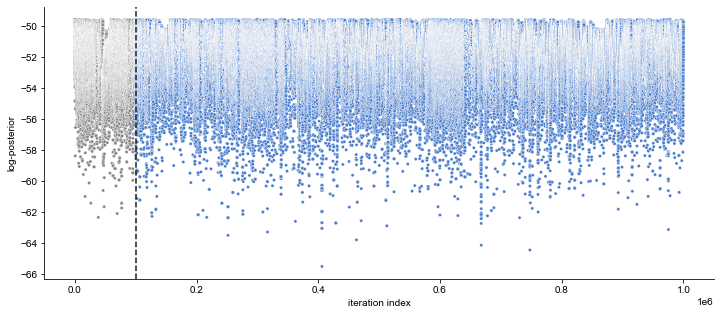

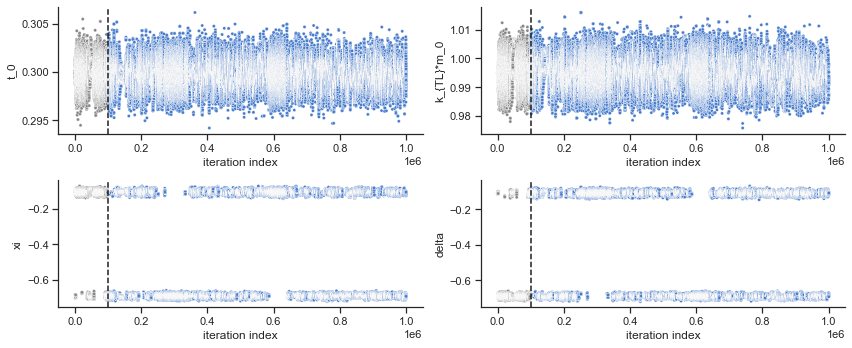

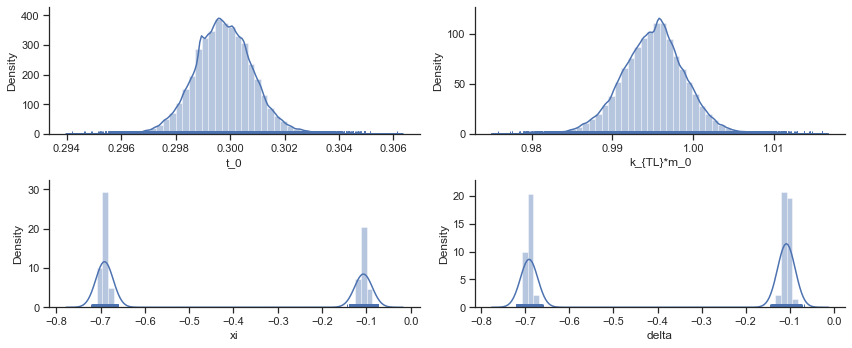

In [9]:
# Visualize the log posterior trace
ax = visualize.sampling_fval_trace(result, size=(12,5), full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))

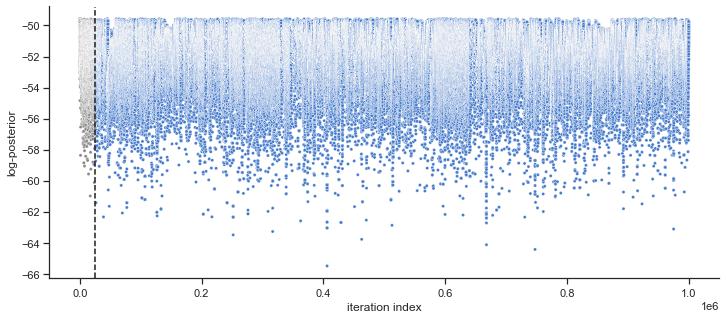

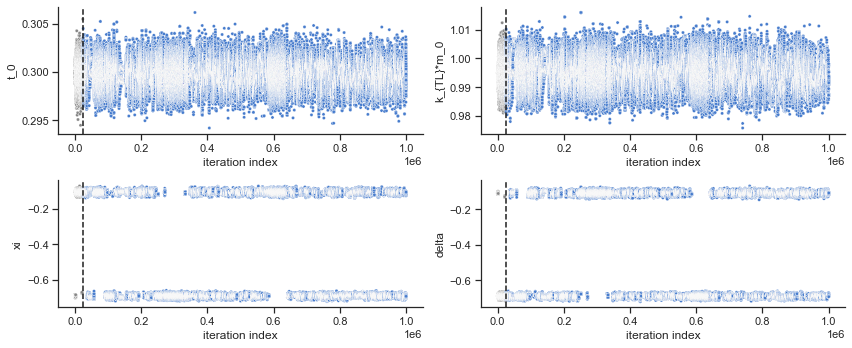

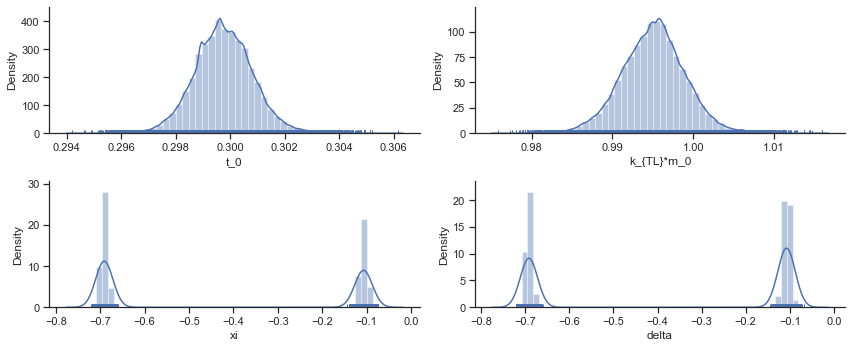

In [10]:
result.sample_result.burn_in = 25000
# Visualize the log posterior trace
ax = visualize.sampling_fval_trace(result, size=(12,5), full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))